In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings("ignore")



df=pd.read_csv('bangalore_rain2.csv')
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
rain = df['Rain(mm)']
df.drop(labels=['Rain(mm)'], axis=1,inplace = True)
df.insert(0, 'Rain(mm)', rain)
df.head()

,Rain(mm),Atm_Pressure(mb),Cloud_Density(%),Humidity(%),Max_Temp(°c),Min_Temp(°c),Wind_Direction,Wind_Speed(Km/h)
Date,,,,,,,,
2018-01-01,0.0,1011.0,11.0,56.0,28.0,17.0,SSE,5.0
2018-01-02,0.0,1011.0,10.0,54.0,28.0,17.0,S,7.0
2018-01-03,0.2,1012.0,18.0,58.0,27.0,19.0,ESE,8.0
2018-01-04,0.0,1013.0,14.0,58.0,27.0,17.0,ENE,12.0
2018-01-05,0.0,1013.0,10.0,53.0,27.0,17.0,E,11.0


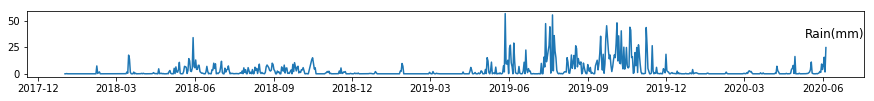

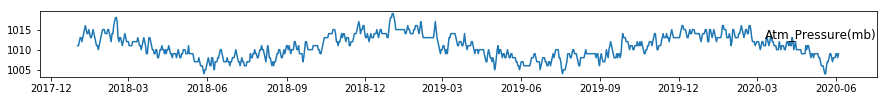

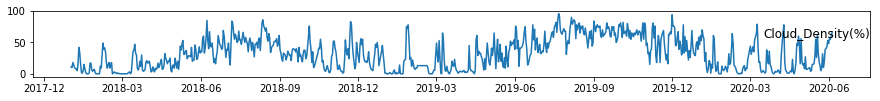

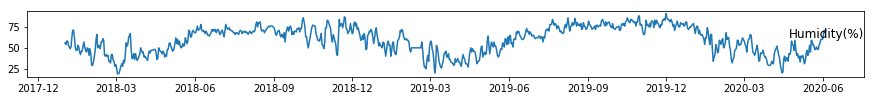

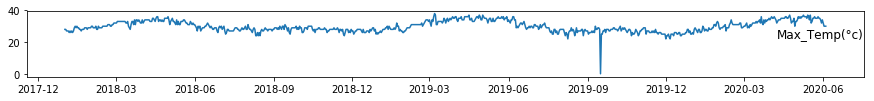

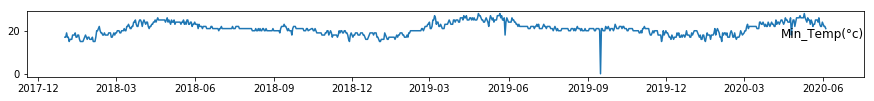

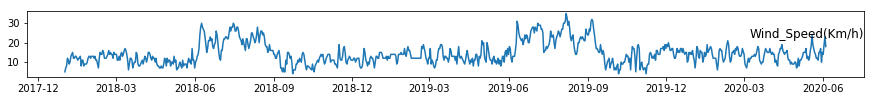

In [92]:
# plot each column
values=df.values
groups = [0, 1, 2, 3, 4, 5, 7]
i = 1
for group in groups:
    plt.figure(figsize=(15, 10))
    plt.subplot(len(groups), 1, i)
    plt.plot(df.index,values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

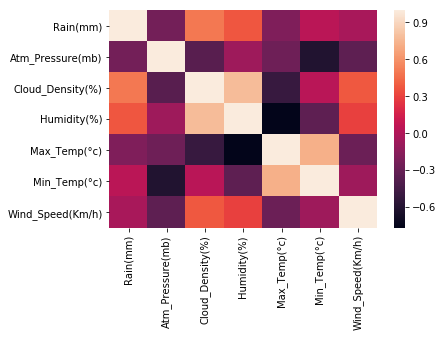

In [93]:
#Correlation Matrix
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [94]:
df_final=df.copy()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_final['Wind_Direction']=le.fit_transform(df_final['Wind_Direction'])

In [138]:
#Split into train and test
cast=365
df_train,df_test=df_final[:-cast],df_final[-cast:]

#Data SCaling and seasonality adjustment
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#df_train = scaler.fit_transform(df_train)

#Fit the VAR model 
lag=365
model = VAR(df_train)
results = model.fit(lag)

In [139]:
lag_order = results.k_ar
r=results.forecast(df_train.values[-lag_order:],cast)

In [140]:
r.shape

(365, 8)

In [141]:
df_forecast = pd.DataFrame(r, index=df_test.index[-cast:], columns=df_test.columns)
df_forecast['Rain(mm)']=[0.0 if w<0 else w for w in df_forecast['Rain(mm)'].values]
#df_forecast['Wind_Direction']=le.inverse_transform(df_forecast['Wind_Direction'])
df_forecast.tail()

,Rain(mm),Atm_Pressure(mb),Cloud_Density(%),Humidity(%),Max_Temp(°c),Min_Temp(°c),Wind_Direction,Wind_Speed(Km/h)
Date,,,,,,,,
2020-05-31,7.250485,1008.437767,2.578299,43.506896,31.433801,21.811105,3.893051,16.257893
2020-06-01,0.000000,1009.046229,-15.786124,40.591910,33.389503,22.165319,-0.246396,16.008964
2020-06-02,3.425783,1009.033810,4.393934,43.119938,33.660624,21.497171,6.301254,14.447103
2020-06-03,13.350990,1009.384560,22.872721,54.038572,32.079134,20.682711,2.755895,17.675417
2020-06-04,0.000000,1007.749844,1.178221,44.798233,34.098670,22.228300,2.927962,13.965716


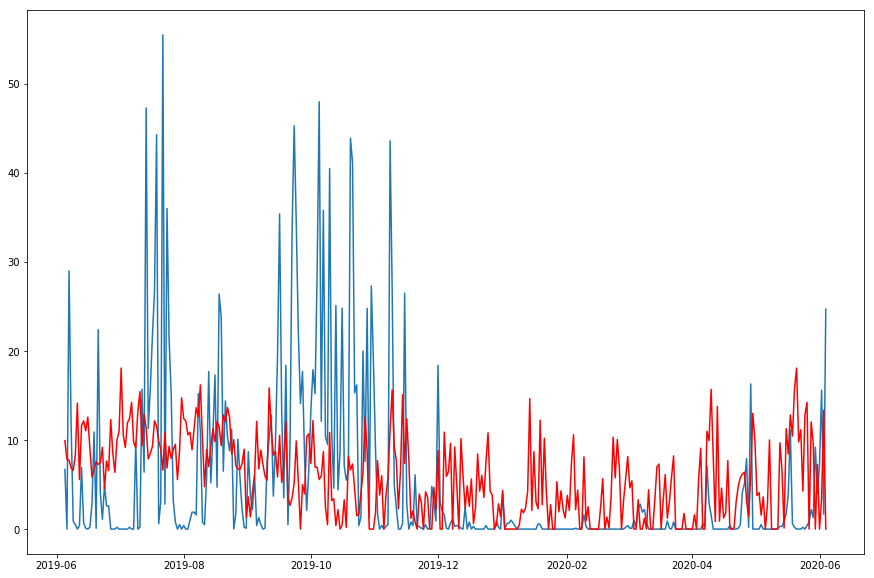

In [142]:
plt.figure(figsize=(15, 10))
plt.plot(df_test.index,df_test['Rain(mm)'])
plt.plot(df_test.index,df_forecast['Rain(mm)'],color='r')